<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Part 3: Quality Monitor and Feedback Logging

### Contents

- [1.0 Install Python Packages](#setup)
- [2.0 Configure Credentials](#credentials)
- [3.0 OpenScale configuration](#openscale)
- [4.0 Get Subscriptions](#subscription)
- [5.0 Quality monitoring and Feedback logging](#quality)

# 1.0 Install Python Packages

In [1]:
!rm -rf /home/spark/shared/user-libs/python3.6*

!pip install --upgrade ibm-ai-openscale==2.2.1 --no-cache --user | tail -n 1
!pip install --upgrade watson-machine-learning-client-V4==1.0.95 | tail -n 1
!pip install --upgrade pyspark==2.3 | tail -n 1

### Action: restart the kernel!

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 2.0 Configure credentials <a name="credentials"></a>

<font color=red>Replace the `username` and `password` values of `************` with your Cloud Pak for Data `username` and `password`. The value for `url` should match the `url` for your Cloud Pak for Data cluster, which you can get from the browser address bar (be sure to include the 'https://'.</font> The credentials should look something like this (these are example values, not the ones you will use):

```
WOS_CREDENTIALS = {
                   "url": "https://zen.clusterid.us-south.containers.appdomain.cloud",
                   "username": "cp4duser",
                   "password" : "cp4dpass"
                  }

```

**NOTE: Make sure that there is no trailing forward slash / in the url**

In [2]:
WOS_CREDENTIALS = {
    "url": "https://zen-cpd-zen.omid-v16-2bef1f4b4097001da9502000c44fc2b2-0000.us-south.containers.appdomain.cloud",
    "username": "jrtorres",
    "password": "*******"
}

In [3]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='3.0.0'

Lets retrieve the variables for the model and deployment we set up in the initial setup notebook. **If the output does not show any values, check to ensure you have completed the initial setup before continuing.**

In [4]:
%store -r MODEL_NAME
%store -r DEPLOYMENT_NAME
%store -r DEFAULT_SPACE

print("Model Name: ", MODEL_NAME, ". Deployment Name: ", DEPLOYMENT_NAME, ". Deployment Space: ", DEFAULT_SPACE)

Model Name:  JRTCreditRiskRFModel-1 . Deployment Name:  RFCreditRiskModelOnlineDep . Deployment Space:  c1b077ce-c625-4861-85e2-6a7273620589


# 3.0 Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and configure OpenScale

In [5]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

In [6]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

In [7]:
ai_client = APIClient4ICP(WOS_CREDENTIALS)
ai_client.version

'2.1.21'

# 4.0 Get Subscription <a name="subscription"></a>

In [8]:
subscription = None

if subscription is None:
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            print("Found existing subscription.")
            subscription = ai_client.data_mart.subscriptions.get(sub)
if subscription is None:
    print("No subscription found. Please run openscale-initial-setup.ipynb to configure.")

Found existing subscription.


### Set Deployment UID

In [9]:
wml_client.set.default_space(DEFAULT_SPACE)

'SUCCESS'

In [10]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    print(deployment['entity']['name'])
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break
        
print(deployment_uid)

WOS-INTERNAL-2d725963-a8af-4c41-821b-15619ae53416
RFCreditRiskModelOnlineDep
0e003bf2-9013-424b-b1a7-8b77ff555427


# 5.0 Quality monitoring and Feedback logging
 <a name="quality"></a>

## 5.1 Enable quality monitoring

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [11]:
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## 5.2 Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [21]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/IBM/credit-risk-workshop-cpd/master/data/openscale/additional_feedback_data.json


--2020-11-17 03:09:17--  https://raw.githubusercontent.com/IBM/credit-risk-workshop-cpd/master/data/openscale/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: ‘additional_feedback_data.json’

100%[======================================>] 16,506      --.-K/s   in 0s      

2020-11-17 03:09:17 (66.2 MB/s) - ‘additional_feedback_data.json’ saved [16506/16506]



In [15]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
    
fields=["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker","Risk"]
subscription.feedback_logging.store(additional_feedback_data['data'], fields=fields)


In [16]:
subscription.feedback_logging.show_table()

no_checking,outstanding_credit,unknown,none,3,greater_7,male,4,unknown,52,free,skilled,2,yes,yes,52,appliances,9249,5,co-applicant,Risk,2020-11-16 22:20:53.032000+00:00
0_to_200,prior_payments_delayed,less_100,none,1,less_1,male,2,savings_insurance,44,own,skilled,1,yes,yes,15,retraining,398,2,co-applicant,No Risk,2020-11-16 22:20:53.032000+00:00
0_to_200,prior_payments_delayed,less_100,none,2,1_to_4,female,1,savings_insurance,32,free,skilled,1,none,yes,16,radio_tv,2373,3,none,No Risk,2020-11-16 22:20:53.035000+00:00
no_checking,prior_payments_delayed,500_to_1000,none,2,4_to_7,male,4,unknown,46,free,skilled,1,yes,yes,38,furniture,8742,3,co-applicant,Risk,2020-11-16 22:20:53.035000+00:00
less_0,prior_payments_delayed,less_100,none,2,1_to_4,male,3,car_other,31,own,skilled,1,none,yes,14,vacation,4398,3,none,No Risk,2020-11-16 22:20:53.036000+00:00
0_to_200,all_credits_paid_back,less_100,none,1,1_to_4,female,1,real_estate,42,own,skilled,1,none,yes,4,car_new,250,2,none,No Risk,2020-11-16 22:20:53.036000+00:00
0_to_200,no_credits,less_100,none,2,less_1,female,2,savings_insurance,32,own,skilled,1,yes,yes,17,car_new,1662,2,none,No Risk,2020-11-16 22:20:53.036000+00:00
0_to_200,credits_paid_to_date,greater_1000,stores,2,1_to_4,male,2,savings_insurance,37,own,unskilled,1,none,no,27,education,1272,3,none,No Risk,2020-11-16 22:20:53.036000+00:00
no_checking,prior_payments_delayed,100_to_500,none,2,greater_7,male,3,savings_insurance,44,free,management_self-employed,1,none,yes,31,vacation,5086,5,none,Risk,2020-11-16 22:20:53.037000+00:00
less_0,prior_payments_delayed,less_100,bank,1,less_1,male,2,car_other,19,rent,unskilled,1,none,yes,15,furniture,3986,2,none,No Risk,2020-11-16 22:20:53.037000+00:00


In [17]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 52c09844-55a6-4237-b612-513362474887 




completed

---------------------------
 Successfully finished run 
---------------------------




In [18]:
subscription.quality_monitoring.show_table()

2020-11-16 22:21:07.763000+00:00,true_positive_rate,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.36363636363636365,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,area_under_roc,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.6433566433566434,0.7,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,precision,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.7058823529411765,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,f1_measure,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.48000000000000004,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,accuracy,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.7346938775510204,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,log_loss,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.4348031675639435,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,false_positive_rate,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.07692307692307693,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,area_under_pr,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.5884262796027502,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427
2020-11-16 22:21:07.763000+00:00,recall,54c922c7-e62c-4139-bb3e-20b1c8e694d2,0.36363636363636365,,,model_type: original,999,aa6d705b-844b-4eef-a7fd-7cd8fad182be,0e003bf2-9013-424b-b1a7-8b77ff555427


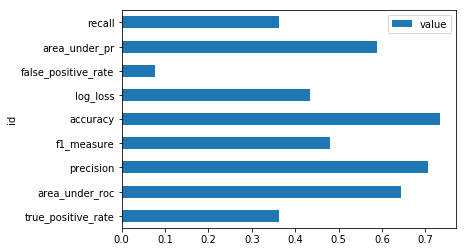

In [19]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

In [20]:
ai_client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': 'e31b0f84-72c7-47aa-9872-64d04dc70ddf',
    'asset_type': 'model',
    'created_at': '2020-11-15T19:45:46.002Z',
    'name': 'JRTCreditRiskRFModel-1',
    'url': 'https://ibm-nginx-svc.zen.svc.cluster.local/v4/models/e31b0f84-72c7-47aa-9872-64d04dc70ddf?space_id=c1b077ce-c625-4861-85e2-6a7273620589'},
   'deployment': {'created_at': '2020-11-15T22:11:54.291Z',
    'deployment_id': '0e003bf2-9013-424b-b1a7-8b77ff555427',
    'deployment_rn': '',
    'deployment_type': 'online',
    'name': 'RFCreditRiskModelOnlineDep',
    'scoring_endpoint': {'request_headers': {'Content-Type': 'application/json'},
     'url': 'https://ibm-nginx-svc.zen.svc.cluster.local/v4/deployments/0e003bf2-9013-424b-b1a7-8b77ff555427/predictions'},
    'url': 'https://ibm-nginx-svc.zen.svc.cluster.local/v4/deployments/0e003bf2-9013-424b-b1a7-8b77ff555427'},
   'metrics': [{'issues': 1,
     'metric_type': 'fairness',
     'timestamp': '2020-11-16T21:53:42.686613Z',
  

## Congratulations!

You have finished this section of the hands-on lab for IBM Watson OpenScale. You can now view the OpenScale dashboard by going to the Cloud Pak for Data `Home` page, and clicking `Services`. Choose the `OpenScale` tile and click the menu to `Open`. Click on the tile for the model you've created to see the monitors.

OpenScale shows model performance over time. You have two options to keep data flowing to your OpenScale graphs:
  * Download, configure and schedule the [model feed notebook](https://raw.githubusercontent.com/emartensibm/german-credit/master/german_credit_scoring_feed.ipynb). This notebook can be set up with your WML credentials, and scheduled to provide a consistent flow of scoring requests to your model, which will appear in your OpenScale monitors.
  * Re-run this notebook. Running this notebook from the beginning will delete and re-create the model and deployment, and re-create the historical data. Please note that the payload and measurement logs for the previous deployment will continue to be stored in your datamart, and can be deleted if necessary.


This notebook has been adapted from notebooks available at https://github.com/pmservice/ai-openscale-tutorials. 